# ssp.train.py

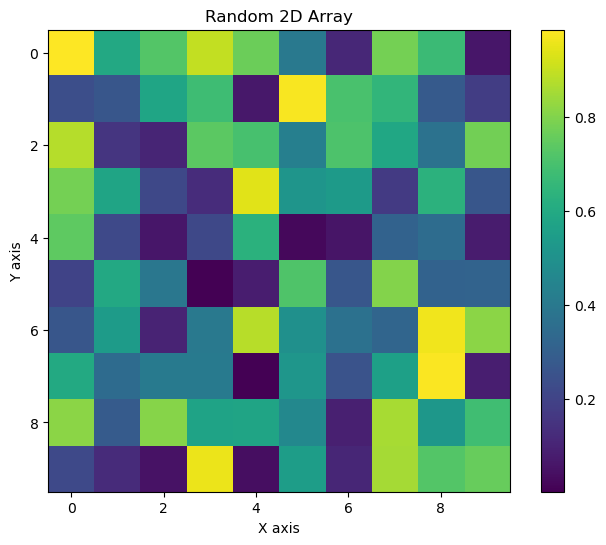

In [1]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time
import sys

# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
def cluster_train_system( 
    gpu = 3,
    Conv_net = True,
    SAE_net = True,

    # hyperparameter
    dataset_num = 16,
    spike_length = 50,
    num_cluster = 4,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = 2400, # 그 초기 몇개까지만 cluster update할지


    batch_size = 32,
    max_epoch = 7000,
    learning_rate = 0.001,
    normalize_on = False, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = False,
    # first_layer_no_train = False
    lif_add_at_first = False,
    my_seed = 42,

    TIME = 10, # SAE일 때만 유효
    v_decay = 0.5,
    v_threshold = 0.5,
    v_reset = 10000.0, # 10000이상 일 시 hard reset
    BPTT_on = True,

    SAE_hidden_nomean = True,
    current_time = '20250101_210938_786',

    optimizer = 'Adam',
    coarse_com_mode = True,
    coarse_com_config = (2.0, -2.0), # (max, min)

    sae_l2_norm_bridge = True,
    sae_lif_bridge = False,

    accuracy_check_epoch_term = 5,
    
    lif_add_at_last = False,

    two_channel_input = False,

    lateral_feature_num = 4,

    lc_adc_on = False, 
    ):
    if coarse_com_mode == True:
        assert coarse_com_config[0] > coarse_com_config[1], 'coarse_com_config[0] > coarse_com_config[1]이어야 함'
        assert SAE_net == True, 'coarse_com_mode는 SAE_net이 True일 때만 가능'
    if two_channel_input == True:
        assert Conv_net and coarse_com_mode, 'two_channel_input는 Conv_net이 True일 때만 가능'
    if lc_adc_on == True:
        assert coarse_com_mode and SAE_net, 'lc_adc_on은 coarse_com_mode와 SAE_net이 True일 때만 가능'

    seed_assign(my_seed)
    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    print(hyperparameters)
    # JSON으로 저장
    with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'w') as f:
        json.dump(hyperparameters, f, indent=4)
    ######################################################################################

    
    wandb.config.update(hyperparameters)
    wandb.run.name = f'{current_time}_SAE_net_{SAE_net}_v_threshold_{v_threshold}'
    wandb.define_metric("best_mean_cluster_accuracy_post_training_cycle_all_dataset2", summary="max")


    my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


    filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
                "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
                "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
                "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


    spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
                "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
                "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
                "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

    label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
                "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
                "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
                "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]

    template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
                "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
                "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
                "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

    AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
    AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

    AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
    AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'

    AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
    AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect

    # thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
    # cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])
    tem=10
    cos_thr = np.array([tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, ])

    print('cos_thr', cos_thr)
    
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= f'{gpu}'


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    if coarse_com_mode == True:
        level_num = TIME
        TIME = spike_length
        spike_length = level_num
        level_interval = (coarse_com_config[0] - coarse_com_config[1]) / (level_num-1)  # max - min
        levels = [coarse_com_config[1] + level_interval * i for i in range(level_num)]
        levels = torch.tensor(levels).to(torch.float).to(device)
        levels = levels.repeat(TIME,1) 
        # print('levels', levels, levels.shape) # TIME, level_num

    n_sample = spike_length

    class spikedataset(Dataset):
        def __init__(self, path, transform = None):    
            self.transform = transform
            self.spike = torch.load(path)
            
        def __getitem__(self, index):
            spike = self.spike[index]            
            if self.transform is not None:
                spike = self.transform(spike)
            return spike
        
        def __len__(self):
            return len(self.spike)

    train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

    test_dataset = spikedataset(my_path_ground_BH + AE_test_data)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)



    # 모델 초기화
    if SAE_net == False:
        if Conv_net == True:
            input_channels = 2 if two_channel_input else 1
            net = Autoencoder_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge)
            net = torch.nn.DataParallel(net)
        else:
            net = Autoencoder_only_FC(encoder_ch=[96, 64, 32, lateral_feature_num], decoder_ch=[32,64,96,n_sample], n_sample=n_sample, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge)
            net = torch.nn.DataParallel(net)
    else:
        if Conv_net == True: 
            input_channels = 2 if two_channel_input else 1
            net = SAE_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                synapse_fc_trace_const1=1, 
                                synapse_fc_trace_const2=v_decay, #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = torch.nn.DataParallel(net)
        else:
            # net = SAE_fc_only(encoder_ch=[96, 64, 32, lateral_feature_num], 
            #                     decoder_ch=[32,64,96,n_sample], 
            #                     in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
            #                     synapse_fc_trace_const1=1,
            #                     synapse_fc_trace_const2=v_decay,  #안씀 
            #                     TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
            #                     sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
            #                     sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = SAE_fc_only(encoder_ch=[400, lateral_feature_num], 
                                decoder_ch=[400, n_sample], 
                                in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                synapse_fc_trace_const1=1,
                                synapse_fc_trace_const2=v_decay,  #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = torch.nn.DataParallel(net)

    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_AE_re_e7000.pth')
    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250101_210938_786.pth')
    # load했으면 torch.nn.DataParallel 하지마
    # net.module.load_state_dict(torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250108_211044_402.pth'))




    wandb.watch(net, log="all", log_freq = 10)





    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__



    net = net.to(device)
    print(f"Total number of encoder parameters: {sum(p.numel() for p in net.module.encoder.parameters())}")
    print(net)
    print('Device:',device)

    
    if optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
    else:
        assert False, 'optimizer를 잘못 입력했습니다.'
        
    loss_history = []
    mean_cluster_accuracy_during_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_post_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_total_all_dataset_history = []

    tau = np.zeros(num_cluster)

    print(f"\nStart Training, current_time = {current_time}")
    mean_cluster_accuracy_post_training_cycle_all_dataset = 0
    best_mean_cluster_accuracy_post_training_cycle_all_dataset = 0

    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__
    
    for epoch in range(max_epoch):
        print()
        ae_train_start_time = time.time()
        running_loss = 0.0
        iter = 0
        net.train()
        for data in train_loader:
            optimizer.zero_grad()
            spike_backup = data
            spike = data
            spike = spike.to(device) # batch, feature
            if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                spike = spike.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                spike = (spike > levels).to(torch.float) 

                spike = (spike == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike

                # spike: batch, time, level_num
                # levels: time, level_num
                if Conv_net == True:
                    spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    if two_channel_input == True:
                        spike_backup = spike_backup.to(device)
                        spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_backup = (spike_backup <= levels).to(torch.float) 
                        spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                        spike_backup = spike_backup.unsqueeze(-2)
                        spike = torch.cat((spike, spike_backup), dim=-2)
                assert spike.shape[0] == batch_size and spike.shape[1] == TIME
            elif 'SAE' in net.module.__class__.__name__:
                spike = spike.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                if Conv_net == True:
                    spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
            else:
                if Conv_net == True:
                    spike = spike.unsqueeze(-2) #batch in_channel,feature

            # for i in range (3):
            #     plot_spike(spike[i,:,0,:].cpu().numpy())
            #     plot_spike(spike[i,:,1,:].cpu().numpy())
            # assert False
                    
            spike_class = net(spike) # batch, time, feature

            if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                # loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                # loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                # loss = loss1 * 2.125 + (loss2 + loss3)/4

                # loss1 = nn.MSELoss()(spike_class[..., 5:25, :], spike[..., 5:25, :])
                # loss2 = nn.MSELoss()(spike_class[..., 0:5, :], spike[..., 0:5, :])
                # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length, :], spike[..., 25:spike_length, :])
                # loss = loss1 * 2.125 + (loss2 + loss3)/4

                loss = nn.MSELoss()(spike_class, spike)
            elif 'SAE' in net.module.__class__.__name__:
                loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                loss = loss1 * 2.125 + (loss2 + loss3)/4
                assert spike_length > 25, 'spike_length가 25보다 작음'
            else:
                loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                loss = loss1 * 2.125 + (loss2 + loss3)/4
                assert spike_length > 25, 'spike_length가 25보다 작음'
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            sys.stdout.write(f'\repoch-{epoch}, running_loss : {running_loss:.5f}, iter percent {iter/len(train_loader)*100:.2f}%')
            sys.stdout.flush()
            # print(f'\nepoch-{epoch}, running_loss : {running_loss:.5f}, iter percent {iter/len(train_loader)*100:.2f}%')
            iter += 1
        avg_loss = running_loss / len(train_loader)
        assert not np.isnan(avg_loss), f"Error: avg_loss is NaN! Running loss: {running_loss}, Length of train_loader: {len(train_loader)}"
        loss_history.append((epoch, avg_loss))
        print(f'\nepoch-{epoch} loss : {avg_loss:.5f}')
        print(f"ae train 실행 시간: {time.time()-ae_train_start_time:.3f}초")





        cluster_accuracy_during_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_post_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_total_all_dataset = np.zeros(dataset_num)    

        if(epoch % accuracy_check_epoch_term == 0 or epoch == 1 or epoch == max_epoch-1): 
            accuracy_check_start_time = time.time()
            print(f'\nepoch-{epoch} accuracy check')
            for ds in range(dataset_num):
                # print('\n', spike_tot[ds])

                spike_template = np.load(my_path_ground_BH + template[ds])
                spike = np.load(my_path_ground_BH + spike_tot[ds])
                label = np.load(my_path_ground_BH + label_tot[ds])
                
                hidden_size = lateral_feature_num*TIME if 'SAE' in net.module.__class__.__name__ and SAE_hidden_nomean == True else lateral_feature_num

                Cluster = np.zeros((num_cluster, hidden_size))
                assert Cluster.shape[-1] == hidden_size, '이거 hidden dim 4 아니게 할 거면 잘 바꿔라'
                
                net.eval()
                with torch.no_grad():
                    spike_torch = torch.from_numpy(spike_template).float()
                    spike_torch = spike_torch[:num_cluster]
                    spike_backup = spike_torch
                    spike_torch = spike_torch.to(device)
                    if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_torch = (spike_torch > levels).to(torch.float) 
                        spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                            if two_channel_input == True:
                                spike_backup = spike_backup.to(device)
                                spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                spike_backup = (spike_backup <= levels).to(torch.float) 
                                spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                spike_backup = spike_backup.unsqueeze(-2) # batch, time, in_channel, feature
                                spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                    elif 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    else:
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                    inner_inf = net.module.encoder(spike_torch)

                    # for i in range(3):
                    #     plot_spike(spike_torch[i,:,:].cpu().numpy())
                    #     plot_spike(inner_inf[i,:].cpu().numpy())
                    #     plot_spike(net.module.decoder(inner_inf)[i,:,:].cpu().numpy())
                        
                    # if 'SAE' in net.module.__class__.__name__:
                    #     tensors = [inner_inf[0][i] for i in range(TIME)] 
                    #     all_equal = all(torch.equal(tensors[0], t) for t in tensors)
                    #     print(all_equal, inner_inf)

                    if 'SAE' in net.module.__class__.__name__:
                        if SAE_hidden_nomean == True:
                            inner_inf = inner_inf.reshape(inner_inf.shape[0],-1)# time*feature 펼치기
                        else:
                            inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균

                    Cluster = inner_inf.cpu().detach().numpy()

                encoder_batch = 128
                spike_hidden = np.zeros((len(spike), hidden_size))
                net.eval()
                with torch.no_grad():
                    now_index = 0
                    while (1):
                        now_end_index = now_index+encoder_batch if now_index+encoder_batch < len(spike) else len(spike)
                        spike_batch = spike[now_index:now_end_index] 
                        spike_torch = torch.from_numpy(spike_batch)
                        spike_torch = spike_torch.float()
                        spike_backup = spike_torch
                        spike_torch = spike_torch.to(device)
                        if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_torch = (spike_torch > levels).to(torch.float) 
                            spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                                if two_channel_input == True:
                                    spike_backup = spike_backup.to(device)
                                    spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                    spike_backup = (spike_backup <= levels).to(torch.float) 
                                    spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                    spike_backup = spike_backup.unsqueeze(-2)
                                    spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                        elif 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        else:
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                                
                        inner_inf = net.module.encoder(spike_torch)
                        if 'SAE' in net.module.__class__.__name__:
                            if SAE_hidden_nomean == True:
                                inner_inf = inner_inf.reshape(spike_batch.shape[0],-1)# 펼치기
                            else:
                                inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                        spike_hidden[now_index:now_end_index] = inner_inf.cpu().detach().numpy()
                        now_index += encoder_batch
                        if (now_index >= len(spike)):
                            break
                    
                spike_id = np.zeros(len(spike))
                distance_sm = np.zeros(num_cluster)
                tau = np.zeros(num_cluster)
                
                plot_tau = []
                plot_denominator = []
                plot_m = []
                plot_max_tau = []
                for spike_index in range(len(spike)): 
                    for q in range(num_cluster):
                        tau[q] = np.dot(spike_hidden[spike_index, :], Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                        denominator =  np.linalg.norm(spike_hidden[spike_index, :])*np.linalg.norm(Cluster[q, :]) + 1e-12
                        plot_denominator.append(denominator)
                        # if True or 'SAE' in net.module.__class__.__name__: # AE 때는 l2norm거쳐서 나와서 괜찮음
                        #     tau[q]
                        #     tau[q] = tau[q] / denominator

                        plot_tau.append(tau[q])

                    # for i in range(num_cluster): # l2 distance
                    #     distance_sm[i] = np.sum(np.power(np.abs(Cluster[i] - spike_hidden[spike_index, :]), 2))
                    distance_sm = np.sum(np.power(np.abs(Cluster - spike_hidden[spike_index, :]), 2), axis=1)

                    m = np.argmin(distance_sm)
                    plot_m.append(m)
                    spike_id[spike_index] = m + 1
                    # print(spike_tot[ds], spike_index,np.max(tau))
                    plot_max_tau.append(np.max(tau))
                    if(np.max(tau) >= cos_thr[ds] and spike_index < training_cycle): # 원래 1400 아니냐?
                        Cluster[m] = (Cluster[m] * 15 + spike_hidden[spike_index, :])/16

                
                # print('Cluster',Cluster)
                # print('spike_id', spike_id)

                # spike id 분포 확인하기
                # unique_elements, counts = np.unique(spike_id, return_counts=True)
                # print("Unique elements:", unique_elements)
                # print("Counts:", counts)

                cluster_accuracy_during_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_post_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_total = np.zeros(math.factorial(num_cluster))
                
                label_converter_ground = list(range(1, num_cluster + 1)) # [1, 2, 3, 4] 생성
                label_converter_permutations = list(itertools.permutations(label_converter_ground)) # 모든 순열 구하기
                perm_i = 0
                perm_start_time = time.time()
                for perm in label_converter_permutations:
                    label_converter = list(perm)
                    # print(label_converter)
                    correct_during_training_cycle = 0
                    correct_post_training_cycle = 0

                    assert len(spike_id) == len(label), 'spike_id랑 label 길이 같아야 됨.'
                    for i in range(len(spike_id)):
                        if(label_converter[int(spike_id[i]-1)] == label[i]):
                            if i < training_cycle:
                                correct_during_training_cycle += 1
                            else:
                                correct_post_training_cycle += 1

                    cluster_accuracy_during_training_cycle[perm_i] = correct_during_training_cycle/training_cycle
                    cluster_accuracy_post_training_cycle[perm_i] = correct_post_training_cycle/(len(spike_id)-training_cycle)
                    cluster_accuracy_total[perm_i] = (correct_during_training_cycle+correct_post_training_cycle)/(len(spike_id))
                    perm_i += 1
                # print(f"perm 실행 시간: {time.time()-perm_start_time:.3f}초")
                
                cluster_accuracy_during_training_cycle_all_dataset[ds] = np.max(cluster_accuracy_during_training_cycle)
                cluster_accuracy_post_training_cycle_all_dataset[ds] = cluster_accuracy_post_training_cycle[np.argmax(cluster_accuracy_during_training_cycle)]
                cluster_accuracy_total_all_dataset[ds] = cluster_accuracy_total[np.argmax(cluster_accuracy_during_training_cycle)]
                # plot_distributions(ds, plot_tau, plot_denominator, plot_m, plot_max_tau, cos_thr[ds],
                #                    cluster_accuracy_during_training_cycle_all_dataset[ds], cluster_accuracy_post_training_cycle_all_dataset[ds], cluster_accuracy_total_all_dataset[ds])

            print('cluster_accuracy_post_training_cycle_all_dataset', cluster_accuracy_post_training_cycle_all_dataset)

            mean_cluster_accuracy_during_training_cycle_all_dataset = np.mean(cluster_accuracy_during_training_cycle_all_dataset)
            mean_cluster_accuracy_post_training_cycle_all_dataset = np.mean(cluster_accuracy_post_training_cycle_all_dataset)
            mean_cluster_accuracy_total_all_dataset = np.mean(cluster_accuracy_total_all_dataset)
            
            mean_cluster_accuracy_during_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_during_training_cycle_all_dataset*100))
            mean_cluster_accuracy_post_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_post_training_cycle_all_dataset*100))
            mean_cluster_accuracy_total_all_dataset_history.append((epoch, mean_cluster_accuracy_total_all_dataset*100))
            print(f"mean_cluster_accuracy_during_training_cycle : {mean_cluster_accuracy_during_training_cycle_all_dataset*100:.2f}%, post_traincycle_acc : {mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%, total_acc : {mean_cluster_accuracy_total_all_dataset*100:.2f}%")

            if mean_cluster_accuracy_post_training_cycle_all_dataset > best_mean_cluster_accuracy_post_training_cycle_all_dataset:
                # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
                torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
                print('save model')
                best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            print(f"best_mean_cluster_accuracy_post_training_cycle_all_dataset : {best_mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%")
            print(f"accuracy_check 실행 시간: {time.time()-accuracy_check_start_time:.3f}초")

        wandb.log({"avg_loss": avg_loss})
        wandb.log({"mean_cluster_accuracy_post_training_cycle_all_dataset": mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset2": best_mean_cluster_accuracy_post_training_cycle_all_dataset})


        # 저장
        with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "wb") as f:
            pickle.dump({
                "loss_history": loss_history,
                "mean_cluster_accuracy_during_training_cycle_all_dataset_history": mean_cluster_accuracy_during_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_post_training_cycle_all_dataset_history": mean_cluster_accuracy_post_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_total_all_dataset_history": mean_cluster_accuracy_total_all_dataset_history,
            }, f)















In [3]:

gpu = 4
Conv_net = True # True False
SAE_net = False  # True False

# hyperparameter
dataset_num = 16
spike_length = 50 # coarse_com_mode일 때는 time step이 됨.
num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
training_cycle = 2400 #1400 2400 # 그 초기 몇개까지만 cluster update할지


batch_size = 32
max_epoch = 7000
learning_rate = 0.001
normalize_on = False # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
need_bias = False
# first_layer_no_train = False
lif_add_at_first = False
my_seed = 42

TIME = 20 # SAE일 때만 유효. coarse_com_mode일 때는 level_num이 됨. 즉 feature 개수.
v_decay = 0.5 # -cor
v_threshold = 0.25 # -cor
v_reset = 10000.0 # -cor # 10000이상 일 시 hard reset
BPTT_on = True # +cor # True False

SAE_hidden_nomean = True # True False

current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

optimizer = 'SGD' #'Adam', 'SGD' # 둘다 준수함. loss 줄이는 거는 adam이 좋긴한데, cluster accuracy는 비슷함.

coarse_com_mode = False # True False
coarse_com_config = (2.0, -2.0) # (max, min) (2.0, -2.0) (3.0, -3.0)

sae_l2_norm_bridge = False # True False
sae_lif_bridge = True # False True

accuracy_check_epoch_term = 1

lif_add_at_last = False # True False

two_channel_input = False # True False

lateral_feature_num = 4

lc_adc_on = False # True False

wandb.init(project= f'spike_sorting just run',save_code=False)


cluster_train_system( 
    gpu = gpu,
    Conv_net = Conv_net,
    SAE_net = SAE_net,

    # hyperparameter
    dataset_num = dataset_num,
    spike_length = spike_length,
    num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


    batch_size = batch_size,
    max_epoch = max_epoch,
    learning_rate = learning_rate,
    normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = need_bias,
    # first_layer_no_train = False
    lif_add_at_first = lif_add_at_first,
    my_seed = my_seed,

    TIME = TIME, # SAE일 때만 유효
    v_decay = v_decay,
    v_threshold = v_threshold,
    v_reset = v_reset, # 10000이상 일 시 hard reset
    BPTT_on = BPTT_on,

    SAE_hidden_nomean = SAE_hidden_nomean,
    
    current_time = current_time,

    optimizer = optimizer, #'Adam', 'SGD'

    coarse_com_mode = coarse_com_mode,
    coarse_com_config = coarse_com_config, # (max, min)

    
    sae_l2_norm_bridge = sae_l2_norm_bridge,
    sae_lif_bridge = sae_lif_bridge,

    accuracy_check_epoch_term = accuracy_check_epoch_term,
    
    lif_add_at_last = lif_add_at_last,

    two_channel_input = two_channel_input,

    lateral_feature_num = lateral_feature_num,

    lc_adc_on = lc_adc_on, 
    )



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


{'gpu': 4, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 7000, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000.0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250110_155353_055', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': (2.0, -2.0)}
cos_thr [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
Total number of encoder parameters: 26592
DataParallel(
  (module): Autoencoder_conv1(
    (encoder): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(3,), stride=

In [ ]:
# # Sweep code


# from unittest import TextTestRunner


# unique_name_hyper = 'cluster_train_system'
# # run_name = 'spike_sorting'
# sweep_start_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
# sweep_configuration = {
#     'method': 'bayes', # 'random', 'bayes'
#     'name': f'spike_sorting_{sweep_start_time}',
#     'metric': {'goal': 'maximize', 'name': 'best_mean_cluster_accuracy_post_training_cycle_all_dataset'},
#     'parameters': 
#     {
#         # "gpu": {"values": [1]},  # 이건 sweep parameter아님. hyper_iter에서 직접 설정
#         "Conv_net": {"values": [False]}, 
#         "SAE_net": {"values": [True]}, 

#         "dataset_num": {"values": [16]}, 
#         "spike_length": {"values": [50]},  
#         "num_cluster": {"values": [4]}, 
#         "training_cycle": {"values": [1400]}, # [1400, 2400]

#         "batch_size": {"values": [32]}, 
#         "max_epoch": {"values": [5]}, 
#         "learning_rate": {"values": [0.001, 0.0001]},
#         "normalize_on": {"values": [False]},
#         "need_bias": {"values": [True, False]}, # [True, False]

#         "lif_add_at_first": {"values": [False]}, # [True, False]
#         "my_seed": {"values": [42]}, 

#         "TIME": {"values": [50,40,30,20]}, #  [4,6,8,10]
#         "v_decay": {"values": [0.25,0.50,0.75,0.875]}, # [0.25,0.50,0.75]
#         "v_threshold": {"values": [0.25,0.50,0.75,1.0]}, # [0.25,0.50,0.75]
#         "v_reset": {"values": [0.0, 10000.0]},  # [0.0, 10000.0]
#         "BPTT_on": {"values": [True, False]},  # [True, False]

#         "SAE_hidden_nomean": {"values": [True]}, # [True, False]

#         # "current_time": {"values": [current_time]} #밑에서 직접설정됨.

#         "optimizer": {"values": ['Adam', 'SGD']}, # ['Adam', 'SGD']

#         "coarse_com_mode": {"values": [True]}, # ['Adam', 'SGD']
#         "coarse_com_config": {"values": [(2.0, -2.0), (3.0, -3.0)]}, # ['Adam', 'SGD']

#         "sae_l2_norm_bridge": {"values": [False]}, # [True, False]
#         "sae_lif_bridge": {"values": [True]}, # [False, True]
        
#         "accuracy_check_epoch_term": {"values": [1]}, 

#         "lif_add_at_last": {"values": [True, False]},# [True, False]

#         "two_channel_input": {"values": [False]},# [True, False]

#         "lateral_feature_num": {"values": [4, 5]},# [True, False]

#         "lc_adc_on": {"values": [True, False]},# [True, False]
#      }
# }


# def hyper_iter():
#     ### my_snn control board ########################
#     wandb.init(save_code = False)
#     gpu  =  2
#     Conv_net  =  wandb.config.Conv_net
#     SAE_net  =  wandb.config.SAE_net

#     dataset_num  =  wandb.config.dataset_num
#     spike_length  =  wandb.config.spike_length
#     num_cluster  =  wandb.config.num_cluster
#     training_cycle  =  wandb.config.training_cycle

#     batch_size  =  wandb.config.batch_size
#     max_epoch  =  wandb.config.max_epoch
#     learning_rate  =  wandb.config.learning_rate
#     normalize_on  =  wandb.config.normalize_on
#     need_bias  =  wandb.config.need_bias

#     lif_add_at_first  =  wandb.config.lif_add_at_first
#     my_seed  =  wandb.config.my_seed


#     TIME  =  wandb.config.TIME
#     v_decay  =  wandb.config.v_decay
#     v_threshold  =  wandb.config.v_threshold
#     v_reset  =  wandb.config.v_reset
#     BPTT_on  =  wandb.config.BPTT_on

#     SAE_hidden_nomean  =  wandb.config.SAE_hidden_nomean
    
#     current_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

#     optimizer  =  wandb.config.optimizer

#     coarse_com_mode = wandb.config.coarse_com_mode
#     coarse_com_config = wandb.config.coarse_com_config # (max, min)

#     sae_l2_norm_bridge = wandb.config.sae_l2_norm_bridge
#     sae_lif_bridge = wandb.config.sae_lif_bridge

#     accuracy_check_epoch_term = wandb.config.accuracy_check_epoch_term

#     lif_add_at_last = wandb.config.lif_add_at_last

#     two_channel_input = wandb.config.two_channel_input

#     lateral_feature_num = wandb.config.lateral_feature_num

#     lc_adc_on = wandb.config.lc_adc_on

#     cluster_train_system( 
#         gpu = gpu,
#         Conv_net = Conv_net,
#         SAE_net = SAE_net,

#         # hyperparameter
#         dataset_num = dataset_num,
#         spike_length = spike_length,
#         num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
#         training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


#         batch_size = batch_size,
#         max_epoch = max_epoch,
#         learning_rate = learning_rate,
#         normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
#         need_bias = need_bias,
#         # first_layer_no_train = False
#         lif_add_at_first = lif_add_at_first,
#         my_seed = my_seed,

#         TIME = TIME, # SAE일 때만 유효
#         v_decay = v_decay,
#         v_threshold = v_threshold,
#         v_reset = v_reset, # 10000이상 일 시 hard reset
#         BPTT_on = BPTT_on,

#         SAE_hidden_nomean = SAE_hidden_nomean,

#         current_time = current_time,

#         optimizer = optimizer, #'Adam', 'SGD'

#         coarse_com_mode = coarse_com_mode,
#         coarse_com_config = coarse_com_config, # (max, min)
        
#         sae_l2_norm_bridge = sae_l2_norm_bridge,
#         sae_lif_bridge = sae_lif_bridge,

#         accuracy_check_epoch_term = accuracy_check_epoch_term,

#         lif_add_at_last = lif_add_at_last,
        
#         two_channel_input = two_channel_input,
        
#         lateral_feature_num = lateral_feature_num,

#         lc_adc_on = lc_adc_on,
#         )
    
# # sweep_id = 'ygoj9jt4'
# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'spike_sorting {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=100000, project=f'spike_sorting {unique_name_hyper}')
        


In [ ]:
wandb.finish() 

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.71997
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71997


{'loss_history': [(0, 0.0)], 'mean_cluster_accuracy_during_training_cycle_all_dataset_history': [(0, 71.41517857142856)], 'mean_cluster_accuracy_post_training_cycle_all_dataset_history': [(0, 71.99704169304977)], 'mean_cluster_accuracy_total_all_dataset_history': [(0, 71.77215455392536)]}


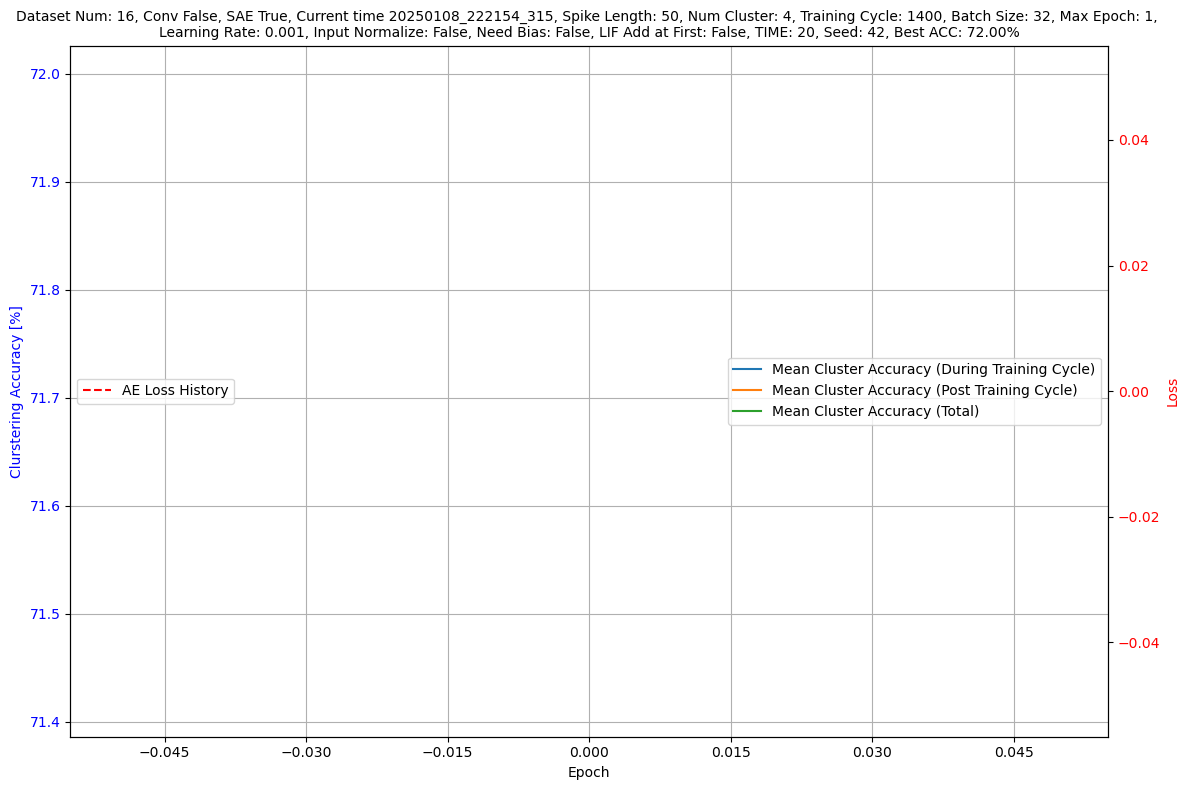

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pickle
import json

# current_time = '20250102_225243_972'

with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "rb") as f:
    data = pickle.load(f)


# JSON으로 저장
with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'r') as f:
    loaded_hyperparameters = json.load(f)

loss_history = data['loss_history']
mean_cluster_accuracy_during_training_cycle_all_dataset_history = data['mean_cluster_accuracy_during_training_cycle_all_dataset_history']
mean_cluster_accuracy_post_training_cycle_all_dataset_history = data['mean_cluster_accuracy_post_training_cycle_all_dataset_history']
mean_cluster_accuracy_total_all_dataset_history = data['mean_cluster_accuracy_total_all_dataset_history']
print(data)
max_acc = 0
for i in mean_cluster_accuracy_post_training_cycle_all_dataset_history:
    if i[1] > max_acc:
        max_acc = i[1]

# 설정 정보 제목 작성
title = (
    f"Dataset Num: {loaded_hyperparameters['dataset_num']}, Conv {loaded_hyperparameters['Conv_net']}, SAE {loaded_hyperparameters['SAE_net']}, Current time {loaded_hyperparameters['current_time']}, Spike Length: {loaded_hyperparameters['spike_length']}, Num Cluster: {loaded_hyperparameters['num_cluster']}, "
    f"Training Cycle: {loaded_hyperparameters['training_cycle']}, Batch Size: {loaded_hyperparameters['batch_size']}, Max Epoch: {loaded_hyperparameters['max_epoch']}, \n"
    f"Learning Rate: {loaded_hyperparameters['learning_rate']}, Input Normalize: {loaded_hyperparameters['normalize_on']}, Need Bias: {loaded_hyperparameters['need_bias']}, "
    f"LIF Add at First: {loaded_hyperparameters['lif_add_at_first']}, TIME: {loaded_hyperparameters['TIME']}, Seed: {loaded_hyperparameters['my_seed']}, Best ACC: {max_acc:.2f}%"
)

# 데이터 리스트와 라벨 설정 (Loss 제외)
data_list = [
    ("Mean Cluster Accuracy (During Training Cycle)", mean_cluster_accuracy_during_training_cycle_all_dataset_history),
    ("Mean Cluster Accuracy (Post Training Cycle)", mean_cluster_accuracy_post_training_cycle_all_dataset_history),
    ("Mean Cluster Accuracy (Total)", mean_cluster_accuracy_total_all_dataset_history),
]

# 플롯 생성
fig, ax1 = plt.subplots(figsize=(12, 8))

# 첫 번째 y축: Accuracy 관련 데이터
for label, data in data_list:
    epochs, values = zip(*data)  # epoch, value 분리
    ax1.plot(epochs, values, label=label)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Clurstering Accuracy [%]", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="center right")
ax1.grid(True)

# x축을 정수만 표시하도록 설정
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# 두 번째 y축: Loss History
ax2 = ax1.twinx()
epochs, values = zip(*loss_history)
ax2.plot(epochs, values, label="AE Loss History", color="red", linestyle="--")
ax2.set_ylabel("Loss", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="center left")

# 제목 추가
plt.title(title, fontsize=10)
plt.tight_layout()
plt.savefig(f'net_save/{current_time}', dpi=300, bbox_inches="tight")  # dpi=300은 고해상도로 저장, bbox_inches="tight"는 여백 최소화
plt.show()


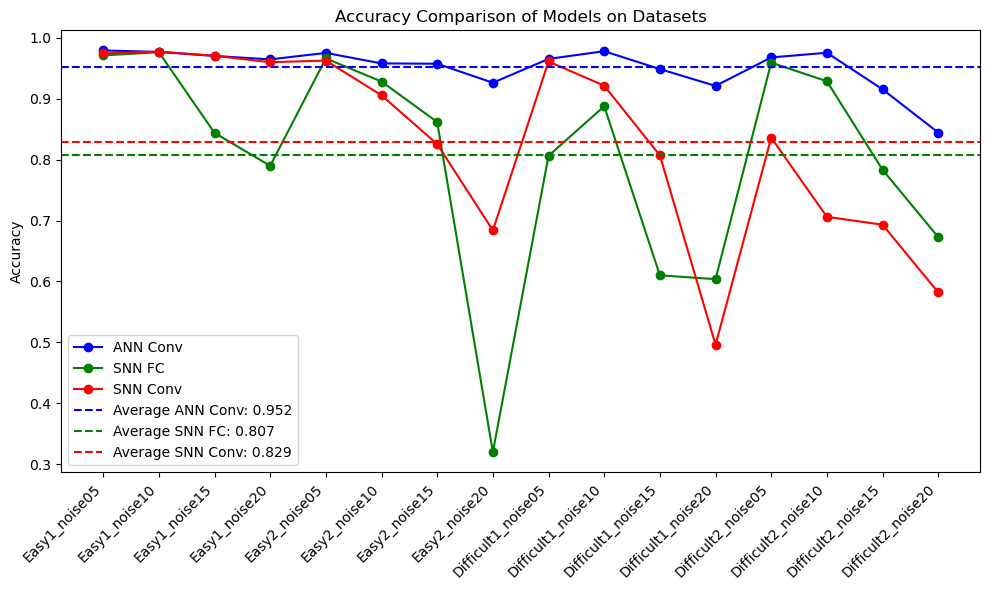

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋
filename_for_plot = [
    "Easy1_noise05", "Easy1_noise10", "Easy1_noise15", "Easy1_noise20",
    "Easy2_noise05", "Easy2_noise10", "Easy2_noise15", "Easy2_noise20",
    "Difficult1_noise05", "Difficult1_noise10", "Difficult1_noise15", "Difficult1_noise20",
    "Difficult2_noise05", "Difficult2_noise10", "Difficult2_noise15", "Difficult2_noise20"
]

# Accuracy 데이터
ANN_conv_accracy_set= [0.97935368, 0.97682709, 0.97028784, 0.96461825, 0.97524752, 0.95803571
, 0.95746785, 0.92628774, 0.965412,  0.97805344, 0.94869403, 0.92110454
, 0.96784232, 0.97551789, 0.91538462, 0.84446478]
SNN_fc_accuracy_set = [0.97114475, 0.97643732, 0.84400578, 0.78977821, 0.96616915, 0.92830189
, 0.86176032, 0.31984948, 0.80635401, 0.88769531, 0.61003861, 0.60377358
, 0.9592668,  0.92870999, 0.78333333, 0.67271859]
SNN_conv_accuracy_set = [0.97445601, 0.97737983, 0.97063072, 0.95998071, 0.96268657, 0.90566038
, 0.82545997, 0.68391345, 0.96116994, 0.92138672, 0.80694981, 0.49602781
, 0.83604888, 0.70611057, 0.69313725, 0.5819398 ]

# 평균 계산
average_ANN_conv = np.mean(ANN_conv_accracy_set)
average_SNN_fc = np.mean(SNN_fc_accuracy_set)
average_SNN_conv = np.mean(SNN_conv_accuracy_set)

# 데이터 준비
accuracies = np.array([ANN_conv_accracy_set, SNN_fc_accuracy_set, SNN_conv_accuracy_set])
averages = np.array([average_ANN_conv, average_SNN_fc, average_SNN_conv])

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 각 모델의 정확도 플롯
ax.plot(accuracies[0], label='ANN Conv', marker='o', linestyle='-', color='blue')
ax.plot(accuracies[1], label='SNN FC', marker='o', linestyle='-', color='green')
ax.plot(accuracies[2], label='SNN Conv', marker='o', linestyle='-', color='red')

# 평균값 플롯
ax.axhline(y=average_ANN_conv, color='blue', linestyle='--', label=f'Average ANN Conv: {average_ANN_conv:.3f}')
ax.axhline(y=average_SNN_fc, color='green', linestyle='--', label=f'Average SNN FC: {average_SNN_fc:.3f}')
ax.axhline(y=average_SNN_conv, color='red', linestyle='--', label=f'Average SNN Conv: {average_SNN_conv:.3f}')

# 레이블 추가
ax.set_xticks(np.arange(len(filename)))
ax.set_xticklabels(filename_for_plot, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Models on Datasets')
ax.legend()

plt.tight_layout()
plt.show()
